In [53]:
# standard library
from collections import namedtuple
import os

# pydata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# bson-numpy libraries
import numpy as np
from bson import CodecOptions
from bson.raw_bson import RawBSONDocument
from pymongo import MongoClient
import bsonnumpy

# other libraries
import maya

In [54]:
# get mongodb params (using configparser)
mlab_uri = os.environ['MLAB_URI']
mlab_collection = os.environ['MLAB_COLLECTION']

In [55]:
codec_options=CodecOptions(document_class=RawBSONDocument)
client = MongoClient(mlab_uri)
db = client.get_default_database()
collection = db.get_collection(
    mlab_collection,
    codec_options=codec_options
)

In [56]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.html#numpy.dtype

In [57]:
# we only pull the fields defined here
dtype = np.dtype(
    [
        ('full_text', 'S400'),
        ('created_at', 'S64'),
        ('retweeted', 'b'),
    ]
)

In [64]:
ndarray = bsonnumpy.sequence_to_ndarray(
    (doc.raw for doc in collection.find()), 
    dtype, 
    collection.count(),
)

In [65]:
print(ndarray)

[ (b'Still. API keys in ipython notebooks! Yikes', b'Sat Dec 16 21:23:32 +0000 2017', 0)
 (b'Fixing up a project I worked on in April 2016. Good job me for documenting sorta well', b'Sat Dec 16 21:22:47 +0000 2017', 0)
 (b'https://t.co/6Ubtx6S1O8\n#bookmark', b'Sat Dec 16 20:45:00 +0000 2017', 0)
 ...,
 (b'Was also logging to AWS CloudWatch. Best practices sorta', b'Sat Dec 16 21:45:38 +0000 2017', 0)
 (b'Got my local dev environment all set up. @droneio builds are also passing. Can finally start working on the business logic! #dockercompose #devops', b'Sun Dec 17 01:06:06 +0000 2017', 0)
 (b'RT @crossphd: Pushpin \xe2\x80\x94 An Open Source Library That Turns REST APIs into Realtime APIs - An intro to evented APIs and how to build them wit\xe2\x80\xa6', b'Sun Dec 17 06:33:45 +0000 2017', 1)]


In [66]:
tweets = pd.DataFrame(ndarray)

In [67]:
tweets.head()

,full_text,created_at,retweeted
0,b'Still. API keys in ipython notebooks! Yikes',b'Sat Dec 16 21:23:32 +0000 2017',0
1,b'Fixing up a project I worked on in April 201...,b'Sat Dec 16 21:22:47 +0000 2017',0
2,b'https://t.co/6Ubtx6S1O8\n#bookmark',b'Sat Dec 16 20:45:00 +0000 2017',0
3,b'RT @dbader_org: A list of things that might ...,b'Sat Dec 16 20:29:52 +0000 2017',1
4,b'VSCode November release \nhttps://t.co/U4nzP...,b'Sat Dec 16 20:23:18 +0000 2017',0


In [68]:
tweets['retweeted'].value_counts()

0    1774
1     795
Name: retweeted, dtype: int64

In [69]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 3 columns):
full_text     2569 non-null object
created_at    2569 non-null object
retweeted     2569 non-null int8
dtypes: int8(1), object(2)
memory usage: 42.7+ KB


### Parse datetime and convert to correct timezone

In [70]:
# create helper function (which we can probably move into sivtools)

ConvertTZArgs = namedtuple("ConvertTZArgs", ["dt_col", "to_timezone"])

def convert_timezone(row, *args):
    # get datetime
    dt_col = args[0].dt_col
    to_timezone = args[0].to_timezone
    dt = row[dt_col]
    
    # get in correct format
    if isinstance(dt, bytes):
        dt = dt.decode('utf-8')
    
    dt = maya.parse(dt).datetime(to_timezone=to_timezone)
    return dt

In [71]:
tweets['created_at'] = tweets.apply(
    convert_timezone,
    axis=1, 
    args=(ConvertTZArgs('created_at', 'US/Central'),)
)

In [72]:
tweets['full_text'] = tweets['full_text'].str.decode('utf-8')

In [73]:
tweets['chars'] = tweets['full_text'].str.len()

In [74]:
tweets.head()

,full_text,created_at,retweeted,chars
0,Still. API keys in ipython notebooks! Yikes,2017-12-16 15:23:32-06:00,0,43
1,Fixing up a project I worked on in April 2016....,2017-12-16 15:22:47-06:00,0,85
2,https://t.co/6Ubtx6S1O8\n#bookmark,2017-12-16 14:45:00-06:00,0,33
3,RT @dbader_org: A list of things that might be...,2017-12-16 14:29:52-06:00,1,140
4,VSCode November release \nhttps://t.co/U4nzPLE8QI,2017-12-16 14:23:18-06:00,0,48


In [75]:
tweets.tail()

,full_text,created_at,retweeted,chars
2564,3D printers are bringing us into the age of St...,2012-12-26 13:30:56-06:00,0,114
2565,Starting up a new public account.,2012-12-26 12:49:53-06:00,0,33
2566,Was also logging to AWS CloudWatch. Best pract...,2017-12-16 15:45:38-06:00,0,56
2567,Got my local dev environment all set up. @dron...,2017-12-16 19:06:06-06:00,0,146
2568,RT @crossphd: Pushpin — An Open Source Library...,2017-12-17 00:33:45-06:00,1,140


In [76]:
tweets.describe(include='all')

,full_text,created_at,retweeted,chars
count,2569,2569,2569.000000,2569.000000
unique,2562,2569,NaN,NaN
top,RT @ThePracticalDev: Git branching done right ...,2016-12-10 00:05:07-06:00,NaN,NaN
freq,2,1,NaN,NaN
mean,NaN,NaN,0.309459,103.272480
std,NaN,NaN,0.462361,33.810651
min,NaN,NaN,0.000000,2.000000
25%,NaN,NaN,0.000000,79.000000
50%,NaN,NaN,0.000000,107.000000
75%,NaN,NaN,1.000000,135.000000


---

## Investigating Number of Characters

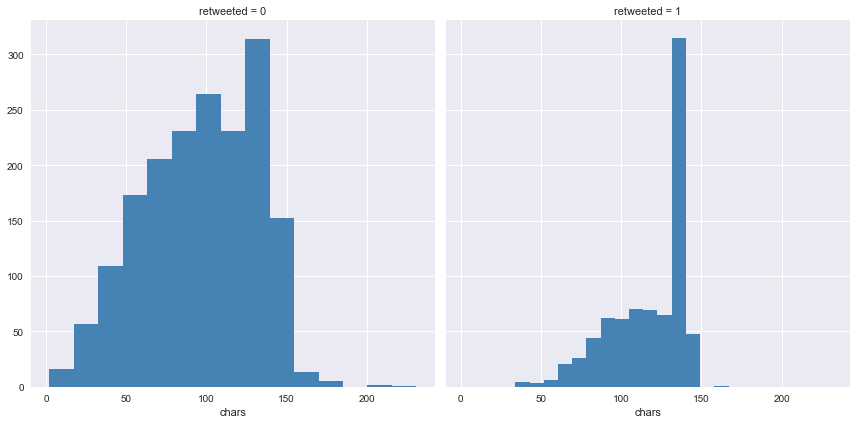

In [77]:
g = sns.FacetGrid(
    tweets,
    col="retweeted",
    margin_titles=True,
    size=6,
)

g.map(
    plt.hist,
    "chars",
    bins=15,
    color="steelblue",
    lw=0,
)

In [78]:
tweets[tweets['retweeted'] == 0]['chars'].describe()

count    1774.000000
mean       96.342728
std        35.101140
min         2.000000
25%        71.000000
50%        98.000000
75%       127.000000
max       231.000000
Name: chars, dtype: float64

In [79]:
tweets[tweets['retweeted'] == 1]['chars'].describe()

count    795.000000
mean     118.735849
std       24.480819
min       34.000000
25%      100.000000
50%      127.000000
75%      140.000000
max      167.000000
Name: chars, dtype: float64

#### Something weird is going on

---

## Examining Time Between Posts

In [80]:
# creating function
def time_between(times):
    sorted_times = times.sort_values()
    time_between = sorted_times - sorted_times.shift(1)
    return time_between

In [81]:
def to_seconds(time):
    return time / np.timedelta64(1, 's')

### Examine time between non-RT posts

In [82]:
between_my_posts = time_between(tweets[tweets['retweeted'] == 0]['created_at'])

In [83]:
between_my_posts.describe()

count                      1773
mean     1 days 00:35:08.163000
std      2 days 00:36:03.828529
min             0 days 00:00:08
25%             0 days 01:36:47
50%             0 days 07:52:01
75%             0 days 23:32:54
max            26 days 03:23:07
Name: created_at, dtype: object

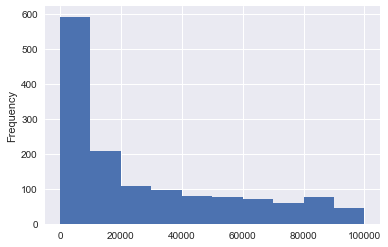

In [84]:
to_seconds(between_my_posts).plot(
    kind='hist',
    range=(0, 100_000)
)

### Examine time between all posts (including RTs)

In [85]:
between_all_posts = time_between(tweets['created_at'])

In [86]:
between_all_posts.describe()

count                      2568
mean     0 days 16:58:35.510903
std      1 days 17:37:38.566048
min             0 days 00:00:03
25%      0 days 00:45:13.750000
50%             0 days 03:12:55
75%      0 days 14:01:24.250000
max            26 days 03:23:07
Name: created_at, dtype: object

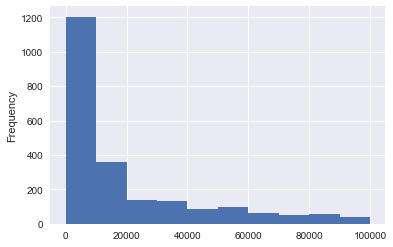

In [87]:
to_seconds(between_all_posts).plot(
    kind='hist',
    range=(0, 100_000)
)

---

# Draw Heatmap

In [88]:
tweets['hour'] = tweets['created_at'].dt.hour
tweets['day_of_week'] = tweets['created_at'].dt.dayofweek

In [89]:
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

### All Posts

In [90]:
tweets_timeline = tweets.groupby(by=['hour', 'day_of_week'])['full_text'].count()

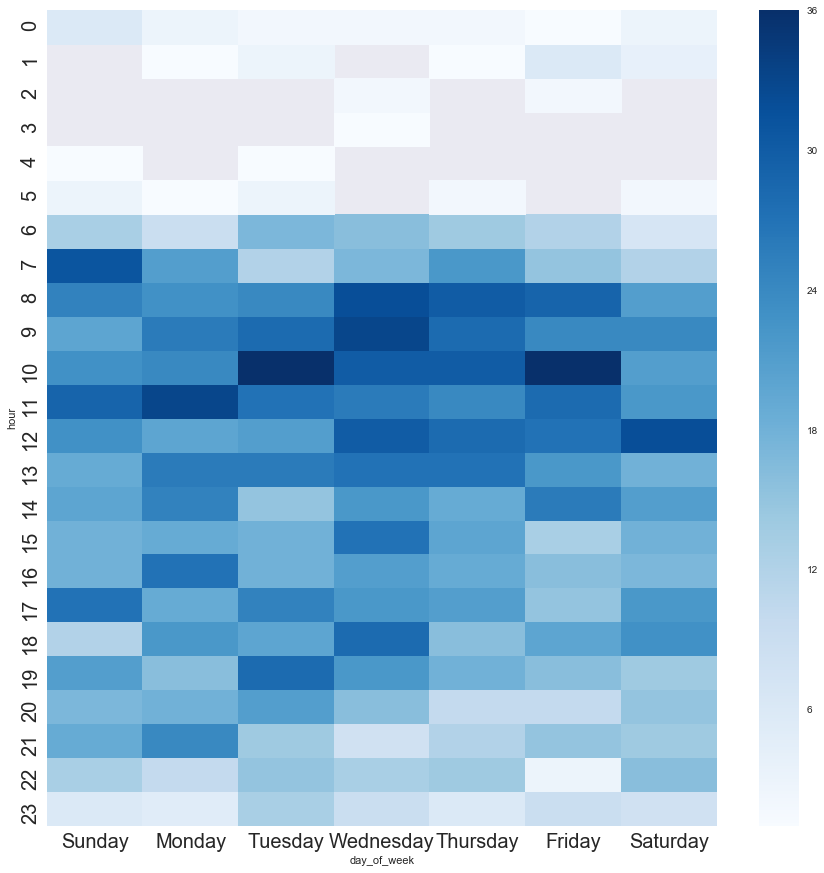

In [91]:
plt.figure(figsize=(15, 15))
ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='Blues',
                  xticklabels=days_of_week))

# Set the tick labels font (#figure out how to send it in as kwargs)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontname('Arial')
    label.set_fontsize(20)

### Original Posts (non-RTed)

In [92]:
tweets_timeline = tweets[tweets['retweeted'] == 0].groupby(by=['hour', 'day_of_week'])['full_text'].count()

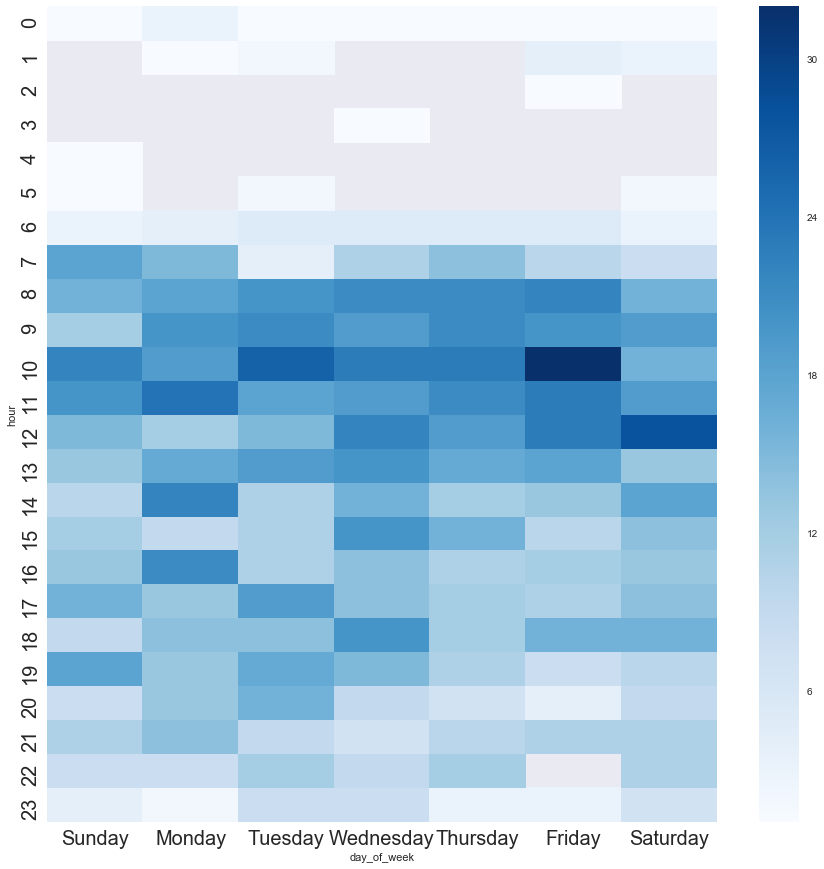

In [93]:
plt.figure(figsize=(15, 15))
ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='Blues',
                  xticklabels=days_of_week))

# Set the tick labels font (#figure out how to send it in as kwargs)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontname('Arial')
    label.set_fontsize(20)